In [18]:
import numpy as np
import pandas as pd
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import c
from astropy.time import Time
from astroquery.jplhorizons import Horizons
import rebound

In [46]:
def Furnisher():
    '''
    This function is used to load all kernels needed in an operation.
    Comment out kernels not in use and add the ones in use.
    
    Arguments: NA
    Returns: NA
    
    '''
    spice.kclear()
    spice.furnsh('/Users/user/Downloads/naif0009.tls.txt')
    #spice.furnsh('/Users/user/Downloads/cas00084.tsc.txt')
    #spice.furnsh('/Users/user/Downloads/cpck05Mar2004.tpc.txt')
    #spice.furnsh('/Users/user/Downloads/020514_SE_SAT105.bsp')
    #spice.furnsh('/Users/user/Downloads/981005_PLTEPH-DE405S.bsp')
    #spice.furnsh('/Users/user/Downloads/030201AP_SK_SM546_T45.bsp')
    #spice.furnsh('/Users/user/Downloads/04135_04171pc_psiv2.bc')
    #spice.furnsh('/Users/user/Downloads/cas_v37.tf.txt')
    #spice.furnsh('/Users/user/Downloads/cas_iss_v09.ti.txt')
    spice.furnsh('/Users/user/Downloads/jup310.bsp')
    spice.furnsh('/Users/user/Downloads/jup341.bsp')
    spice.furnsh('/Users/user/Downloads/de435.bsp')
    pass

In [47]:
Furnisher()

In [26]:
def get_spice_function(name,cor,loc):
    """
    This wrapper function automates the creation of objects through the JPL Horizons database. 
    
    Arguments:
    
    name: str
    
    Stipulates the target object in Horizons. The major bodies in the Solar System have an id based on their position.
    Hence '5' refers to Jupiter and '3' to Earth. A single number designator refers to a barycenter and a designator
    such as '599' to the planetary center. For minor bodies in the Solar System, the id_type in the Horizons
    must be changed to "minorbody"
    
    cor: str
    
    Refers to the type of correction that the object has. Available arguments are 'NONE', 'LT','LT+S'
    
    loc: str
    
    Designates the location of observation. Names that start with "g@#" refer to barycenters where the number designates the 
    body that the observer is based at. Hence "g@0" refers to the Solar System barycenter. Also takes Earth location designators.
    Observatories are named after their code. Hence, Pan-Starrs observatory is referred as "f51"

    Returns:
    
    get_target_xyz function
    """    
    def get_target_xyz(t):
        """
        Returns the vectors of the Horizons body at a certain time t.
        
        Arguments:
        
        t: days
        
        Julian date of observation
        
        Returns:
    
        xyz: numpy array
        
        A position vector of the observed object
    
        uvw: numpy array
        
        An instantaneous velocity vector of the observed object
        
        radec: numpy array
        
        The right ascension and declination of the observed object
        """
        
        state,lighttime = spice.spkezr(name,t,'J2000',cor,loc)
        pos,lighttime = spice.spkpos(name,t,'J2000',cor,loc)
        range,ra,dec = spice.recrad(pos) 
        xyz = np.array([state[0],state[1],state[2]])*6.68459e-9
        uvw = np.array([state[3],state[4],state[5]])*6.68459e-9
        radec = np.array([ra,dec])
        return xyz,uvw,radec*180/np.pi
    return get_target_xyz

In [192]:
(7.179289*10**12)/(1.327124400189*10**20)

5.409657903190971e-08

Starting the simulation

In [193]:
mj = 0.0009545942707553125
me = 3.0034896639925697e-06
mv = 2.4478481441056744e-06
mars = 3.227155795937493e-07
mm = 1.660198546335387e-07
ms = 0.0002858148632833373
mur = 4.3657850757433644e-05
mnept = 5.151385882910742e-05
mio = 4.490849538408931e-08
meur = 2.41329222757406e-08
mga = 7.450570570921492e-08
mcal = 5.409657903190971e-08
man = 1.92099771e-14

In [200]:
def SimStart(bsolar,msolar,iJovian):
    t = 140961664.18440723
    sim = rebound.Simulation()
    k = 0.0172020989484
    sim.G = k**2
    sim.units = ('d', 'AU', 'Msun')
    get_sun = get_spice_function('Sun','NONE','SOLAR SYSTEM BARYCENTER')
    xyz,uvw,radec = get_sun(t) #Adding the Sun
    xyz = xyz
    uvw = (uvw*24*3600)
    sim.add(m=1,x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    for i in range(0,len(bsolar)):
        get_planet = get_spice_function(bsolar[i],'NONE','SOLAR SYSTEM BARYCENTER')
        xyz,uvw,radec = get_planet(t) #Adding Jupiter
        xyz = xyz
        uvw = (uvw*24*3600)
        sim.add(m=msolar[i],x=xyz[0],y=xyz[1],z=xyz[2],vx=uvw[0],vy=uvw[1],vz=uvw[2])
    ps = sim.particles
    for j in range(1,len(ps)):
        if j not in iJovian:
            print(ps[j].calculate_orbit(primary=ps[0]))
        else:
            print(ps[j].calculate_orbit(primary=ps[bsolar.index('Jupiter')+1]))
    return ps,sim

In [202]:
def Integrator(bsolar,msolar,iJovian,body1,body2):
    ps,sim = SimStart(bsolar,msolar,iJovian)
    xm = []
    ym = []
    Nout = 10000
    year = 365.25 # days
    day = 86400 # s
    tmax = 10*year
    t0 = 140961664.18440723
    times = np.linspace(0, tmax, Nout) # days
    x = np.zeros((len(bsolar)+1,Nout))
    y = np.zeros((len(bsolar)+1,Nout))
    get_ear_an = get_spice_function(body1,'NONE',body2)
    for i, time in enumerate(times):
        tspice = t0 + time*day
        sim.integrate(time)
        for j in range(0,len(bsolar)+1):
            x[j][i] = ps[j].x   # This stores the data which allows us to plot it later
            y[j][i] = ps[j].y
        xyz,uvw,radec = get_ear_an(tspice)
        xm.append(xyz[0])
        ym.append(xyz[1])
    return x,y,xm,ym,times

In [170]:
x,y,xm,ym,times = Integrator(['3','5','Ananke','1','2'],[me,mj,man,mm,mv],[3],'Ananke','3')
x2,y2,xm2,ym2,times = Integrator(['3','5','Ananke','1'],[me,mj,man,mm,mv],[3],'Ananke','3')

<rebound.Orbit instance, a=0.9999930266382379 e=0.01672620834380971 inc=0.4090821617741168 Omega=-2.6488883546935366e-07 omega=1.795143590190808 f=-3.384211765643985>
<rebound.Orbit instance, a=5.20184126093362 e=0.04896128244397236 inc=0.40552494729662064 Omega=0.05673854765073144 omega=0.20559785719353837 f=2.7466278990708877>
<rebound.Orbit instance, a=0.14323865545604103 e=0.3494232759141472 inc=2.843150696190118 Omega=1.5168448654607531 omega=2.947805234530009 f=-3.893906465435246>
<rebound.Orbit instance, a=0.3870988663871473 e=0.20563002961706725 inc=0.4983341103811051 Omega=0.19174989178676657 omega=1.179349621287842 f=0.308088527853027>
<rebound.Orbit instance, a=0.7233384484485751 e=0.006764980420496777 inc=0.4264483255574286 Omega=0.13974876508932377 omega=2.169803878939286 f=-3.7582988019904073>
<rebound.Orbit instance, a=0.9999930266382379 e=0.01672620834380971 inc=0.4090821617741168 Omega=-2.6488883546935366e-07 omega=1.795143590190808 f=-3.384211765643985>
<rebound.Orbit

Error is higher without Saturn in the system

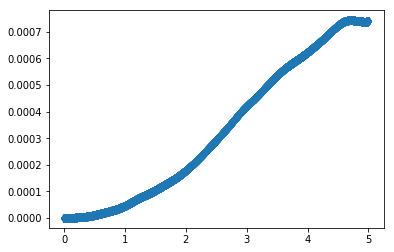

In [168]:
k = (np.array(x[3]-x[1])-np.array(xm)) - (np.array(x2[3]-x2[1])-np.array(xm2))
#plt.plot(times/365.25,(np.array(x[3]-x[1])-np.array(xm)),"d")
plt.plot(times/365.25,k,"d")

Error is more choppy with Venus in the system

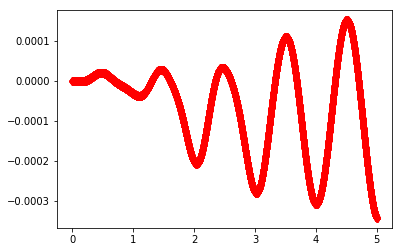

In [173]:
hj = (np.array(x[3]-x[1])-np.array(xm)) - (np.array(x2[3]-x2[1])-np.array(xm2))
#plt.plot(times/365.25,(np.array(x[3]-x[1])-np.array(xm)),"d")
plt.plot(times/365.25,hj,"d",color = 'red')

Best result

<rebound.Orbit instance, a=0.3870988663871473 e=0.20563002961706725 inc=0.4983341103811051 Omega=0.19174989178676657 omega=1.179349621287842 f=0.308088527853027>
<rebound.Orbit instance, a=0.7233384484485751 e=0.006764980420496777 inc=0.4264483255574286 Omega=0.13974876508932377 omega=2.169803878939286 f=-3.7582988019904073>
<rebound.Orbit instance, a=0.9999930266382379 e=0.01672620834380971 inc=0.4090821617741168 Omega=-2.6488883546935366e-07 omega=1.795143590190808 f=-3.384211765643985>
<rebound.Orbit instance, a=1.5236928366207634 e=0.09348139583298948 inc=0.4306991269449783 Omega=0.05884538386386866 omega=-0.4716018328382698 f=2.7671074235413418>
<rebound.Orbit instance, a=5.202048987276908 e=0.04891847885198181 inc=0.40552514554358376 Omega=0.05673845103279668 omega=0.20573268973365186 f=2.746493094953867>
<rebound.Orbit instance, a=9.574064476162334 e=0.05669302484179552 inc=0.39360386430418387 Omega=0.1038037268845539 omega=1.548995050057417 f=0.2068116263299542>
<rebound.Orbit 

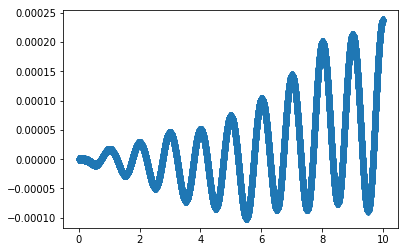

In [203]:
x,y,xm,ym,times = Integrator(['1','2','3','4','Jupiter','6','7','8','Io','Europa','Ganymede','Callisto','Ananke'],[mm,mv,me,mars,mj,ms,mur,mnept,mio,meur,mga,mcal,man],[9,10,11,12,13],'Ananke','3')
plt.plot(times/365.25,(np.array(x[13]-x[3])-np.array(xm)),"d")

In [244]:
def ErrorSource(bsolar,mass,iJovian,b1,b2):
    x,y,xm,ym,times = Integrator(bsolar,mass,iJovian,b1,b2)
    dist1 = x[bsolar.index(b1)+1] - x[bsolar.index(b2)+1]
    dist2 = y[bsolar.index(b1)+1] - y[bsolar.index(b2)+1]
    return np.array(dist1-xm),np.array(dist2-ym),times

Best result

In [245]:
xerr,yerr,times = ErrorSource(['1','2','3','4','Jupiter','6','7','8','Io','Europa','Ganymede','Callisto','Ananke'],[mm,mv,me,mars,mj,ms,mur,mnept,mio,meur,mga,mcal,man],[9,10,11,12,13],'Ananke','3')


<rebound.Orbit instance, a=0.3870988663871473 e=0.20563002961706725 inc=0.4983341103811051 Omega=0.19174989178676657 omega=1.179349621287842 f=0.308088527853027>
<rebound.Orbit instance, a=0.7233384484485751 e=0.006764980420496777 inc=0.4264483255574286 Omega=0.13974876508932377 omega=2.169803878939286 f=-3.7582988019904073>
<rebound.Orbit instance, a=0.9999930266382379 e=0.01672620834380971 inc=0.4090821617741168 Omega=-2.6488883546935366e-07 omega=1.795143590190808 f=-3.384211765643985>
<rebound.Orbit instance, a=1.5236928366207634 e=0.09348139583298948 inc=0.4306991269449783 Omega=0.05884538386386866 omega=-0.4716018328382698 f=2.7671074235413418>
<rebound.Orbit instance, a=5.202048987276908 e=0.04891847885198181 inc=0.40552514554358376 Omega=0.05673845103279668 omega=0.20573268973365186 f=2.746493094953867>
<rebound.Orbit instance, a=9.574064476162334 e=0.05669302484179552 inc=0.39360386430418387 Omega=0.1038037268845539 omega=1.548995050057417 f=0.2068116263299542>
<rebound.Orbit 

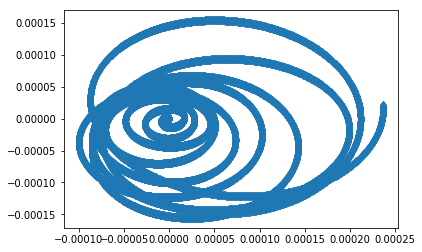

In [246]:
plt.plot(xerr,yerr,"d")

Just the three bodies

In [247]:
xerr,yerr,times = ErrorSource(['3','Jupiter','Ananke'],[me,mj,man],[3],'Ananke','3')


<rebound.Orbit instance, a=0.9999930266382379 e=0.01672620834380971 inc=0.4090821617741168 Omega=-2.6488883546935366e-07 omega=1.795143590190808 f=-3.384211765643985>
<rebound.Orbit instance, a=5.202048987276908 e=0.04891847885198181 inc=0.40552514554358376 Omega=0.05673845103279668 omega=0.20573268973365186 f=2.746493094953867>
<rebound.Orbit instance, a=0.1432598750662984 e=0.3494009634123075 inc=2.8431041670859956 Omega=1.5170537953754362 omega=2.9484640523355323 f=-3.8943657238645226>


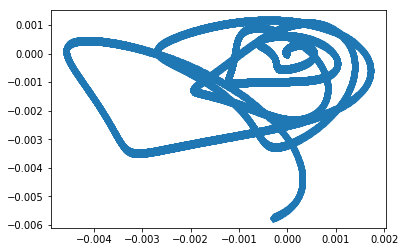

In [248]:
plt.plot(xerr,yerr,"d")

Saturn as well

In [251]:
xerr,yerr,times = ErrorSource(['3','Jupiter','Ananke','6'],[me,mj,man,ms],[3],'Ananke','3')


<rebound.Orbit instance, a=0.9999930266382379 e=0.01672620834380971 inc=0.4090821617741168 Omega=-2.6488883546935366e-07 omega=1.795143590190808 f=-3.384211765643985>
<rebound.Orbit instance, a=5.202048987276908 e=0.04891847885198181 inc=0.40552514554358376 Omega=0.05673845103279668 omega=0.20573268973365186 f=2.746493094953867>
<rebound.Orbit instance, a=0.1432598750662984 e=0.3494009634123075 inc=2.8431041670859956 Omega=1.5170537953754362 omega=2.9484640523355323 f=-3.8943657238645226>
<rebound.Orbit instance, a=9.574064476162334 e=0.05669302484179552 inc=0.39360386430418387 Omega=0.1038037268845539 omega=1.548995050057417 f=0.2068116263299542>


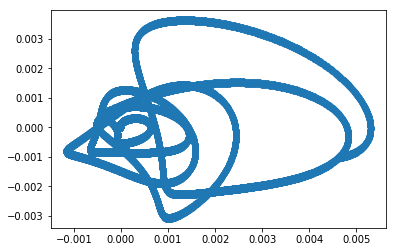

In [252]:
plt.plot(xerr,yerr,"d")

Saturn and Venus

In [254]:
xerr,yerr,times = ErrorSource(['3','Jupiter','Ananke','6','2'],[me,mj,man,ms,mv],[3],'Ananke','3')


<rebound.Orbit instance, a=0.9999930266382379 e=0.01672620834380971 inc=0.4090821617741168 Omega=-2.6488883546935366e-07 omega=1.795143590190808 f=-3.384211765643985>
<rebound.Orbit instance, a=5.202048987276908 e=0.04891847885198181 inc=0.40552514554358376 Omega=0.05673845103279668 omega=0.20573268973365186 f=2.746493094953867>
<rebound.Orbit instance, a=0.1432598750662984 e=0.3494009634123075 inc=2.8431041670859956 Omega=1.5170537953754362 omega=2.9484640523355323 f=-3.8943657238645226>
<rebound.Orbit instance, a=9.574064476162334 e=0.05669302484179552 inc=0.39360386430418387 Omega=0.1038037268845539 omega=1.548995050057417 f=0.2068116263299542>
<rebound.Orbit instance, a=0.7233384484485751 e=0.006764980420496777 inc=0.4264483255574286 Omega=0.13974876508932377 omega=2.169803878939286 f=-3.7582988019904073>


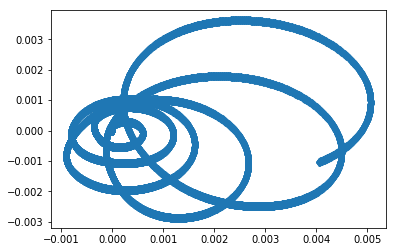

In [255]:
plt.plot(xerr,yerr,"d")

Saturn Venus and Io

In [256]:
xerr,yerr,times = ErrorSource(['3','Jupiter','Ananke','6','2','Io'],[me,mj,man,ms,mv,mio],[3,6],'Ananke','3')


<rebound.Orbit instance, a=0.9999930266382379 e=0.01672620834380971 inc=0.4090821617741168 Omega=-2.6488883546935366e-07 omega=1.795143590190808 f=-3.384211765643985>
<rebound.Orbit instance, a=5.202048987276908 e=0.04891847885198181 inc=0.40552514554358376 Omega=0.05673845103279668 omega=0.20573268973365186 f=2.746493094953867>
<rebound.Orbit instance, a=0.1432598750662984 e=0.3494009634123075 inc=2.8431041670859956 Omega=1.5170537953754362 omega=2.9484640523355323 f=-3.8943657238645226>
<rebound.Orbit instance, a=9.574064476162334 e=0.05669302484179552 inc=0.39360386430418387 Omega=0.1038037268845539 omega=1.548995050057417 f=0.2068116263299542>
<rebound.Orbit instance, a=0.7233384484485751 e=0.006764980420496777 inc=0.4264483255574286 Omega=0.13974876508932377 omega=2.169803878939286 f=-3.7582988019904073>
<rebound.Orbit instance, a=0.00282103616687832 e=0.0035669200174323966 inc=0.4454712677814145 Omega=-0.03249725622222026 omega=-1.321144114457784 f=2.932931190735662>


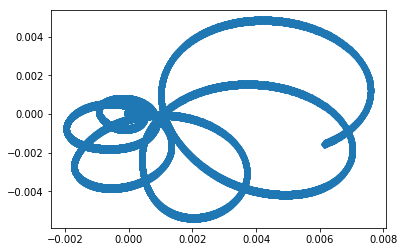

In [257]:
plt.plot(xerr,yerr,"d")

Venus, Saturn, Io and Mercury

In [258]:
xerr,yerr,times = ErrorSource(['3','Jupiter','Ananke','6','2','Io','1'],[me,mj,man,ms,mv,mio,mm],[3,6],'Ananke','3')


<rebound.Orbit instance, a=0.9999930266382379 e=0.01672620834380971 inc=0.4090821617741168 Omega=-2.6488883546935366e-07 omega=1.795143590190808 f=-3.384211765643985>
<rebound.Orbit instance, a=5.202048987276908 e=0.04891847885198181 inc=0.40552514554358376 Omega=0.05673845103279668 omega=0.20573268973365186 f=2.746493094953867>
<rebound.Orbit instance, a=0.1432598750662984 e=0.3494009634123075 inc=2.8431041670859956 Omega=1.5170537953754362 omega=2.9484640523355323 f=-3.8943657238645226>
<rebound.Orbit instance, a=9.574064476162334 e=0.05669302484179552 inc=0.39360386430418387 Omega=0.1038037268845539 omega=1.548995050057417 f=0.2068116263299542>
<rebound.Orbit instance, a=0.7233384484485751 e=0.006764980420496777 inc=0.4264483255574286 Omega=0.13974876508932377 omega=2.169803878939286 f=-3.7582988019904073>
<rebound.Orbit instance, a=0.00282103616687832 e=0.0035669200174323966 inc=0.4454712677814145 Omega=-0.03249725622222026 omega=-1.321144114457784 f=2.932931190735662>
<rebound.Orb

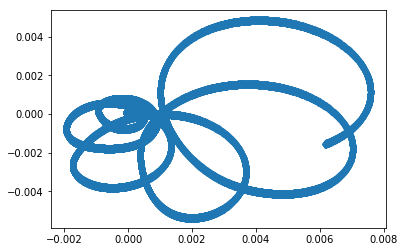

In [259]:
plt.plot(xerr,yerr,"d")